# Apresentação
Este notebook se refere à resolução de um case do processo seletivo para a posição de Cientista de Dados Jr na empresa Zeta Dados.
A proposta era criar 8 polos de venda com 50 pontos de venda para indústria de sorvetes Gelarte na cidade de São Paulo.

# Contexto Notebook
Este notebook em específico está sendo usado para otimizar os hiperparâmetros. do problema. Não conseguimos aperfeiçoar o código de modo a gerar 8 polos com exatamente 50 pontos de venda, mas mantivemos o registro para fins de aperfeiçoamento futuro.

Observe o que está sendo feito no código abaixo:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

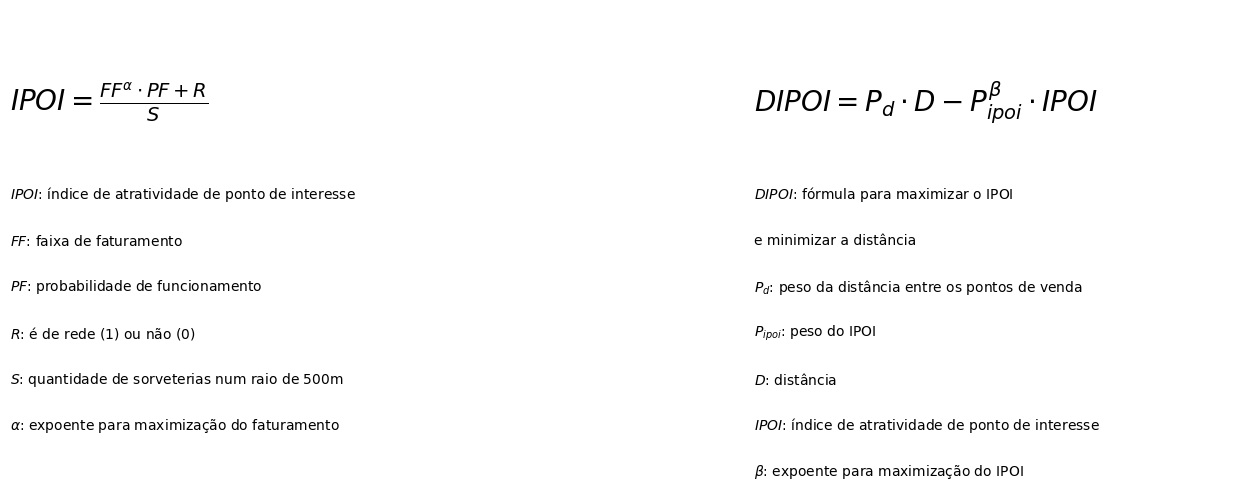

In [ ]:
import matplotlib.pyplot as plt

# criar a figura
fig, ax = plt.subplots(figsize=(16, 6))  # tamanho maior para melhor visualização
ax.axis('off')  # remover eixos

# definir fórmulas
formula_esquerda = r"$IPOI = \frac{FF^\alpha \cdot PF + R}{S}$"
formula_direita = r"$DIPOI = P_{d} \cdot D - P_{ipoi}^\beta \cdot IPOI$"

# definir legendas
legenda_esquerda = [
    r"$IPOI$: índice de atratividade de ponto de interesse",
    r"$FF$: faixa de faturamento",
    r"$PF$: probabilidade de funcionamento",
    r"$R$: é de rede (1) ou não (0)",
    r"$S$: quantidade de sorveterias num raio de 500m",
    r"$\alpha$: expoente para maximização do faturamento"
]

legenda_direita = [
    r"$DIPOI$: fórmula para maximizar o IPOI",
    r"e minimizar a distância",
    r"$P_{d}$: peso da distância entre os pontos de venda",
    r"$P_{ipoi}$: peso do IPOI",
    r"$D$: distância",
    r"$IPOI$: índice de atratividade de ponto de interesse",
    r"$\beta$: expoente para maximização do IPOI"
]

# posicionar fórmulas
plt.text(0, 0.8, formula_esquerda, fontsize=20, ha='left', va='center', fontweight='bold')
plt.text(0.6, 0.8, formula_direita, fontsize=20, ha='left', va='center', fontweight='bold')

# posicionar legendas abaixo das fórmulas
y_pos_esquerda = 0.6
y_pos_direita = 0.6

for linha in legenda_esquerda:
    plt.text(0, y_pos_esquerda, linha, fontsize=10, ha='left', va='center')
    y_pos_esquerda -= 0.1

for linha in legenda_direita:
    plt.text(0.6, y_pos_direita, linha, fontsize=10, ha='left', va='center')
    y_pos_direita -= 0.1

# exibir gráfico
plt.show()

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
import os
from itertools import product
import datetime

def load_and_preprocess_data():
    """Load and preprocess the initial dataset."""
    df = pd.read_excel("https://raw.githubusercontent.com/jaxrosil/zetadados/main/Base_prospeccao.xlsx")

    # tratamento
    objetos = df.select_dtypes(include=['object']).columns
    df[objetos] = df[objetos].apply(lambda x: x.str.strip())
    df = df.drop(df.loc[df['ID'] == 195159].index)

    # filtrar categorias
    aux_alimenticio = pd.read_excel('https://raw.githubusercontent.com/jaxrosil/zetadados/main/Zeta%20Dados%20-%20Case%20-%20Categorias.xlsx', sheet_name='Query')
    aux_alimenticio['Alimentício'] = aux_alimenticio['Alimentício'].astype(int)

    alimenticio = aux_alimenticio.pivot_table(
        index='Categoria',
        columns='Fonte',
        values='Alimentício',
        aggfunc='first'
    ).reset_index()

    alimenticio['Alimentício'] = (alimenticio['GPT obj'] + alimenticio['GPT sub'] + alimenticio['Manual'] >= 2).astype(int)

    df['Alimentício'] = df['Categoria Detalhada'].map(alimenticio.set_index('Categoria')['Alimentício'])
    df = df.query("`Alimentício` == 1")
    df['De Rede'] = (df['Rede'] != '').astype(int)
    df = df.query('`Probabilidade de Funcionamento` != "Fechado"')

    return process_categories(df)

def process_categories(df):
    """Process and encode categories."""
    faturamento_ordem = ['Até R$81mil', 'Entre R$81mil e R$360mil', 'Entre R$360mil e R$4.8MM',
                        'Entre R$4.8MM Até R$10MM', 'Maior que R$10MM']
    probabilidade_ordem = ['Baixíssima', 'Baixa', 'Média', 'Alta', 'Muito alta']

    df['Faixa de Faturamento'] = pd.Categorical(df['Faixa de Faturamento'],
                                               categories=faturamento_ordem,
                                               ordered=True)
    df['Faixa de Faturamento'] = df['Faixa de Faturamento'].cat.codes + 1

    df['Probabilidade de Funcionamento'] = pd.Categorical(df['Probabilidade de Funcionamento'],
                                                        categories=probabilidade_ordem,
                                                        ordered=True)
    df['Probabilidade de Funcionamento'] = df['Probabilidade de Funcionamento'].cat.codes + 1

    return df

def calculate_ice_cream_poi(gdf, cidade="São Paulo, Brazil", raio=500):
    """Calculate ice cream POIs."""
    pois_ice_cream = ox.features_from_place(cidade, {"amenity": "ice_cream"})
    gdf_ice_cream = gpd.GeoDataFrame(pois_ice_cream, geometry=pois_ice_cream.geometry, crs="EPSG:4326")

    gdf = gdf.to_crs("EPSG:31983")
    gdf_ice_cream = gdf_ice_cream.to_crs("EPSG:31983")

    def contar_pontos_vizinhos(ponto, gdf_pois):
        return gdf_pois.geometry.within(ponto.buffer(raio)).sum()

    gdf["qtd_ice_cream"] = gdf.geometry.apply(lambda x: contar_pontos_vizinhos(x, gdf_ice_cream))
    return gdf

def haversine(latlon1, latlon2):
    """Calculate Haversine distance."""
    lat1, lon1 = np.deg2rad(latlon1)
    lat2, lon2 = np.deg2rad(latlon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    radius = 6371000
    return radius * c

def calculate_distances_and_clusters(gdf, w_dist, w_ipoi, pow_fat, pow_ipoi):
    """Calculate distances and perform clustering."""
    # cálculo IPOI
    IPOI_preliminar = (gdf["Probabilidade de Funcionamento"] * (gdf["Faixa de Faturamento"]**pow_fat) + gdf['De Rede'])
    gdf["Idx_POI"] = (IPOI_preliminar**(pow_ipoi))/(gdf["qtd_ice_cream"]+1)

    # normalização IPOI
    gdf['Idx_POI_normalizado'] = MinMaxScaler().fit_transform(gdf[['Idx_POI']])

    # distâncias
    gdf = gdf.to_crs("EPSG:4326")
    coordenadas = np.array([(ponto.x, ponto.y) for ponto in gdf.geometry])
    distancias = pdist(coordenadas, metric=haversine)
    distancias = squareform(distancias)
    distancias_normalizadas = MinMaxScaler().fit_transform(distancias)

    # distâncias + POI
    distancias_idx_poi_combinado = (w_dist * distancias_normalizadas) - (w_ipoi * gdf['Idx_POI_normalizado'].values[:, None])

    # clusterização
    n_polos = 8
    kmeans = KMeans(n_clusters=n_polos, random_state=42, n_init=10)
    gdf['polo_temp'] = kmeans.fit_predict(distancias_idx_poi_combinado)

    gdf['polo_venda'] = -1
    for polo in range(n_polos):
        pontos_do_polo = gdf[gdf['polo_temp'] == polo]
        if len(pontos_do_polo) > 50:
            pontos_do_polo = pontos_do_polo.nlargest(50, 'Idx_POI_normalizado')
        gdf.loc[pontos_do_polo.index, 'polo_venda'] = polo

    gdf = gdf.query('polo_venda != -1')
    gdf.drop(columns=['polo_temp'], inplace=True)
    return gdf

def create_map(base_final, timestamp, params):
    """Create and save map visualization."""
    cores_polos = [
        'rgb(255, 99, 132)', 'rgb(54, 162, 235)', 'rgb(255, 206, 86)',
        'rgb(75, 192, 192)', 'rgb(153, 102, 255)', 'rgb(255, 159, 64)',
        'rgb(0, 204, 255)', 'rgb(204, 0, 204)'
    ]

    fig = go.Figure()

    fig.add_trace(go.Scattermapbox(
        lat=base_final['Latitude'],
        lon=base_final['Longitude'],
        mode='markers',
        marker=dict(
            size=8,
            color=[cores_polos[int(polo)] for polo in base_final['polo_venda']],
            opacity=0.7
        ),
        text=base_final['polo_venda'].astype(str),
        hoverinfo='text',
        name='Pontos de Venda Gelarte',
    ))

    for i, cor in enumerate(cores_polos):
        fig.add_trace(go.Scattermapbox(
            lat=[None],
            lon=[None],
            mode='markers',
            marker=dict(size=10, color=cor),
            name=f'Polo {i}',
            showlegend=True
        ))

    param_text = f"pow_fat:{params['pow_fat']}_pow_ipoi:{params['pow_ipoi']}_w_ipoi:{params['w_ipoi']}_w_dist:{params['w_dist']}"

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=11,
        mapbox_center={"lat": -23.5505, "lon": -46.6333},
        title=f"Polos de venda da Gelarte na cidade de São Paulo - {param_text}",
        title_x=0.5,
        title_font=dict(size=24, color='black'),
        template="plotly",
        margin={"r":0,"t":30,"l":0,"b":0},
        legend_title="Polos de Venda",
        legend=dict(
            orientation='v',
            x=1.05,
            y=0.5,
            xanchor='left',
            yanchor='middle'
        ),
        showlegend=True
    )

    # criar diretório se não existir
    os.makedirs('mapas', exist_ok=True)

    # salvar mapa
    fig.write_html(f'mapas/mapa_{param_text}_{timestamp}.html')
    return fig

def calculate_metrics(base_final):
    """Calculate and return metrics."""

    media_polos = base_final.groupby('polo_venda').agg({
        'Faixa de Faturamento': lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Handle empty mode
        'Probabilidade de Funcionamento': lambda x: x.mode()[0] if not x.mode().empty else np.nan
    }).reset_index()

    media_polos.columns = ['polo_venda', 'FatMed', 'FuncMed']

    base_final["geometry"] = base_final.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    base_final = gpd.GeoDataFrame(base_final, geometry='geometry', crs="EPSG:4326") # Set CRS here

    # distâncias com geometria
    distancias_medias = []
    for polo, grupo in base_final.groupby("polo_venda"):
        if len(grupo) > 1:
            coordenadas = np.array([(p.y, p.x) for p in grupo.geometry])
            distancias = pdist(coordenadas, metric=haversine)
            distancia_media = np.mean(distancias)
        else:
            distancia_media = 0
        distancias_medias.append({"polo_venda": polo, "distancia_media": distancia_media})

    df_distancias_medias = pd.DataFrame(distancias_medias)

    fat_med_global = base_final['Faixa de Faturamento'].mean()
    func_med_global = base_final['Probabilidade de Funcionamento'].mean()

    return {
        'redes_total': base_final['De Rede'].sum(),
        'media_por_polo': media_polos,
        'medias_globais': (fat_med_global, func_med_global),
        'distancias_medias': df_distancias_medias,
        'distancia_media_global': df_distancias_medias['distancia_media'].mean()
    }
def save_results_to_excel(all_results, filename='resultados_completos.xlsx'):
    """Save all results to a single Excel file."""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        #sumarização
        summary_data = []
        medias_polo_data = []
        distancias_data = []

        for result in all_results:
            params = result['params']
            metrics = result['metrics']


            summary_data.append({
                'pow_fat': params['pow_fat'],
                'pow_ipoi': params['pow_ipoi'],
                'w_ipoi': params['w_ipoi'],
                'w_dist': params['w_dist'],
                'total_redes': metrics['redes_total'],
                'distancia_media_global': metrics['distancia_media_global'],
                'fat_med_global': metrics['medias_globais'][0],
                'func_med_global': metrics['medias_globais'][1]
            })

            # médias por polo
            media_polo_df = metrics['media_por_polo'].copy()
            media_polo_df['pow_fat'] = params['pow_fat']
            media_polo_df['pow_ipoi'] = params['pow_ipoi']
            media_polo_df['w_ipoi'] = params['w_ipoi']
            media_polo_df['w_dist'] = params['w_dist']
            medias_polo_data.append(media_polo_df)

            # distâncias médias
            dist_df = metrics['distancias_medias'].copy()
            dist_df['pow_fat'] = params['pow_fat']
            dist_df['pow_ipoi'] = params['pow_ipoi']
            dist_df['w_ipoi'] = params['w_ipoi']
            dist_df['w_dist'] = params['w_dist']
            distancias_data.append(dist_df)

        # salvar
        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Resumo', index=False)
        pd.concat(medias_polo_data).to_excel(writer, sheet_name='Médias por Polo', index=False)
        pd.concat(distancias_data).to_excel(writer, sheet_name='Distâncias Médias', index=False)

# wrap up
def run_analysis(params):
    """Run complete analysis with given parameters."""
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

    # tratamento
    df = load_and_preprocess_data()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
    gdf.crs = "EPSG:4326"

    # IPOI
    gdf = calculate_ice_cream_poi(gdf)

    # distância e cluster
    base_final = calculate_distances_and_clusters(
        gdf,
        params['w_dist'],
        params['w_ipoi'],
        params['pow_fat'],
        params['pow_ipoi']
    )

    # criar e salvar mapa
    create_map(base_final, timestamp, params)

    # métricas
    results = calculate_metrics(base_final)

    return {
        'params': params,
        'metrics': results
    }

# rodar tudo testanto hiperparâmetros
if __name__ == '__main__':
    # Define hyperparameter grid
    hiperparametros = {
        'pow_fat': [1, 2],
        'pow_ipoi': [1, 2],
        'w_ipoi': [5, 10],
        'w_dist': [5, 10]
    }

    # combinações hiperparâmetros
    param_combinations = [dict(zip(hiperparametros.keys(), v))
                        for v in product(*hiperparametros.values())]

    # salvar resultados
    all_results = []

    # rodar tudo
    for params in tqdm(param_combinations):
        print(f"Running analysis with parameters: {params}")
        results = run_analysis(params)
        all_results.append(results)
        print("Analysis complete\n")

    # salvar resultados em um excel
    print("Saving all results to Excel...")
    save_results_to_excel(all_results)
    print("Analysis completed successfully!")

  0%|          | 0/16 [00:00<?, ?it/s]

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 1, 'w_ipoi': 5, 'w_dist': 5}


  6%|▋         | 1/16 [00:39<09:55, 39.69s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 1, 'w_ipoi': 5, 'w_dist': 10}


 12%|█▎        | 2/16 [01:10<08:01, 34.42s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 1, 'w_ipoi': 10, 'w_dist': 5}


 19%|█▉        | 3/16 [01:41<07:07, 32.88s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 1, 'w_ipoi': 10, 'w_dist': 10}


 25%|██▌       | 4/16 [02:11<06:22, 31.91s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 2, 'w_ipoi': 5, 'w_dist': 5}


 31%|███▏      | 5/16 [02:41<05:40, 30.93s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 2, 'w_ipoi': 5, 'w_dist': 10}


 38%|███▊      | 6/16 [03:11<05:07, 30.77s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 2, 'w_ipoi': 10, 'w_dist': 5}


 44%|████▍     | 7/16 [03:41<04:33, 30.39s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 1, 'pow_ipoi': 2, 'w_ipoi': 10, 'w_dist': 10}


 50%|█████     | 8/16 [04:10<04:00, 30.10s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 1, 'w_ipoi': 5, 'w_dist': 5}


 56%|█████▋    | 9/16 [04:39<03:28, 29.83s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 1, 'w_ipoi': 5, 'w_dist': 10}


 62%|██████▎   | 10/16 [05:09<02:59, 29.83s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 1, 'w_ipoi': 10, 'w_dist': 5}


 69%|██████▉   | 11/16 [05:39<02:29, 29.85s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 1, 'w_ipoi': 10, 'w_dist': 10}


 75%|███████▌  | 12/16 [06:12<02:02, 30.69s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 2, 'w_ipoi': 5, 'w_dist': 5}


 81%|████████▏ | 13/16 [06:41<01:30, 30.32s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 2, 'w_ipoi': 5, 'w_dist': 10}


 88%|████████▊ | 14/16 [07:11<01:00, 30.26s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 2, 'w_ipoi': 10, 'w_dist': 5}


 94%|█████████▍| 15/16 [07:41<00:30, 30.02s/it]

Analysis complete

Running analysis with parameters: {'pow_fat': 2, 'pow_ipoi': 2, 'w_ipoi': 10, 'w_dist': 10}


100%|██████████| 16/16 [08:10<00:00, 30.67s/it]

Analysis complete

Saving all results to Excel...
Analysis completed successfully!
